In [7]:
from cmath import inf
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import sympy as sy
from sympy import *
import math
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, HBox, VBox, Layout, Dropdown
from IPython.display import display
import ipywidgets as widgets

In [8]:
### warnings ###
np.warnings.filterwarnings('error', category=np.VisibleDeprecationWarning)                                                                                           

### symbols ###
x = Symbol('x')

In [9]:
class ClassRoots:
    def __init__(self):
        pass

    def rootsearch(self,f,a,b,dx):
        x1 = a; f1 = f(a)
        x2 = a + dx; f2 = f(x2)
        while f1*f2 > 0.0:
            if x1 >= b:
                return None,None
            x1 = x2; f1 = f2
            x2 = x1 + dx; f2 = f(x2)
        return x1,x2

    def bisect(self, f,x1,x2,switch=0,epsilon=1.0e-9):
        f1 = f(x1)
        if f1 == 0.0:
            return x1
        f2 = f(x2)
        if f2 == 0.0:
            return x2
        if f1*f2 > 0.0:
            #print('Root is not bracketed')
            return None
        n = int(math.ceil(math.log(abs(x2 - x1)/epsilon)/math.log(2.0)))
        for i in range(n):
            x3 = 0.5*(x1 + x2); f3 = f(x3)
            if (switch == 1) and (abs(f3) >abs(f1)) and (abs(f3) > abs(f2)):
                return None
            if f3 == 0.0:
                return x3
            if f2*f3 < 0.0:
                x1 = x3
                f1 = f3
            else:
                x2 =x3
                f2 = f3
        return (x1 + x2)/2.0

    def roots(self,f, a, b, eps=1e-6):
        #print ('The roots on the interval [%f, %f] are:' % (a,b))
        zeros = []
        while 1:
            x1,x2 = self.rootsearch(f,a,b,eps)
            if x1 != None:
                a = x2
                root = self.bisect(f,x1,x2,1)
                if root != None:
                    pass
                    #print (round(root,-int(math.log(eps, 10))))
                    zeros.append(round(root,-int(math.log(eps, 10))))
            else:
                #print(zeros)
                #print ('\nDone')
                break
        return zeros

In [10]:
### methods ###

def g():
    """Example function for inital surface"""
    return -abs(x)

def isfloat(num):
    """Check if input is a float"""
    try:
        float(num)
        return True
    except ValueError:
        return False
    except TypeError:
        return False

def transformer_function(values, func, xShift):
    """
    Transforms expression of a function into a numpy expression and returns a tupel of x and y values

    values: values of x-coordinate
    func: function that is transformed into a numpy expression
    xShift: shift of x-coordinates
    """
    if isfloat(func):
        npFunc = [func for i in range(len(values))]
        return values + xShift, npFunc
    npFunc = lambdify(x, func, 'numpy')
    return values + xShift, npFunc(values)

def transformer_vector(values, vector):
    """
    Transforms expression of a vector into a numpy expression
    
    vector[0] is the 
    vector[1] is just 1 (since we only use it for the normal vector of the form (f'(x), 1)
    """
    npFunc0 = lambdify(x, vector[0], 'numpy')
    #npFunc1 = lambdify(x, vector[1], 'numpy')
    npFunc1 = np.array([vector[1] for i in range(len(values))])
    return npFunc0(values), npFunc1

def normal_vector(func):
    """
    Calculates normal vector of simply parametrized function in the Euclidean norm and returns a tupel of sympy expressions.
    
    Simply parametrized here means, that it is of the form (x, f(x))
    """
    funcPrime = func.diff(x)
    return -funcPrime, 1

def minkowski_normal_vector(func):
    """Calculates normal vector of a simply parametrized functioon in the minkowski norm and returns a tupel of sympy expressions."""
    funcPrime = func.diff(x)
    return funcPrime, 1

def normal_of_segment(x):
    """
    Return tangent vector of a two line segments

    x: list of values
    """
    u = []
    v = []
    for i in range(len(x)):
        if x[i] > 0:
            u.append(1 / np.sqrt(2))
            v.append(1/ np.sqrt(2))
        else: 
            u.append(-1 / np.sqrt(2))
            v.append(1 / np.sqrt(2))
    return u,v 

def normic(values, func):
    """Return normic values"""
    if isfloat(func):
        f = [0 for i in range(len(values))]
        values = [1 for i in range(len(values))]
        return f, values
    else:
        return unit_vector(transformer_vector(values, normal_vector(func)))

def minkowski_normic(values, func):
    "Return normic values"
    if isfloat(func):
        f = [0 for i in range(len(values))]
        values = [1 for i in range(len(values))]
        return f, values
    return minkowski_unit_vector(transformer_vector(values, minkowski_normal_vector(func)))

def unit_vector(vector):
    """Normalize vector"""
    return vector[0] / norm(vector), vector[1] / norm(vector)

def minkowski_unit_vector(vector):
    """Normalize vector"""
    norm = minkowski_norm(vector)
    if any(entry == 0 for entry in norm) == False:
            return vector[0] / norm, vector[1] / norm

def norm(vector):
    """Calculates Euclidean norm of vector"""
    return np.sqrt(vector[0]**2 + vector[1]**2)

def minkowski_norm(vector):
    """Calculates Minkowski norm of vector"""
    # (+---) signature
    radicand = np.abs(vector[0]**2 - vector[1]**2)
    return np.sqrt(radicand)

def inner_product2D(v, w):
    """
    Calculates the scalar product of two 2 dimensional vectors
     
    v: list of two floats representing x and y coordinate
    w: list of two floats representing x and y coordinate
    """
    return v[0] * w[0] + v[1] * w[1]

def angle_between_vectors(v,w):
    """Returns angle between two 2D vectors"""
    return np.arccos(inner_product2D(v / np.linalg.norm(v), w / np.linalg.norm(w)))

def circle(t, center):
    """
    Draw a unit circle around a point

    t: list of parameters
    a: point at which the unit circle is drawn
    """
    return center[0] + np.cos(t), center[1] + np.sin(t)

def circle(t, center, radius):
    """Returns circle with given radius centered around a given point"""
    x = center[0] + np.cos(t) * radius
    y = center[1] + np.sin(t) * radius
    return x, y 

def curvature(func):
    """Calculates signed curvature of initial surface"""
    funcPrime = func.diff()
    func2Prime = funcPrime.diff()
    k = func2Prime / (1 + funcPrime**2)**(3 / 2)
    return k

def extrema(func, values):
    """Finds extrem points of function"""
    funcPrime = func.diff()
    npFuncPrime = lambdify(x, funcPrime, 'numpy')
    cr = ClassRoots()
    roots = cr.roots(npFuncPrime, *values)
    return roots

def osculating_circle(point, func):
    """Calculates the osculating circle of a function"""
    px, py = point
    if isfloat(func): return 0,0,0
    # function and its derivatives
    funcPrime = func.diff()
    func2Prime = funcPrime.diff()
    # function and its derivatives into numpy
    npFuncPrime = lambdify(x, funcPrime, 'numpy')
    npFunc2Prime = lambdify(x, func2Prime, 'numpy')
    # calculate radius of oculating circle
    if npFunc2Prime(px) == 0: return 0,0,0
    else:
        r = np.abs(((1 + npFuncPrime(px) ** 2) ** (3 / 2)) / npFunc2Prime(px))
        # calculate center of osculating circle
        kx = px - (npFuncPrime(px)*(1 + npFuncPrime(px)**2)) / npFunc2Prime(px)
        ky = py + (1 + npFuncPrime(px)**2) / npFunc2Prime(px)
        #plt.plot(kx, ky, 'ro')
    return r, kx, ky

def find_duplicates(list):
    """Returns duplicates in a given list"""
    seen = set()
    uniq = []
    duplicates = []
    for x in list:
        if x not in seen:
            uniq.append(x)
            seen.add(x)
        else:
            duplicates.append(x)
    return duplicates

def normic_values(xValues, s, func, xShift):
    "Returns the values of the normic for all times s from an interval sValues"
    if isfloat(func):
        func = [func for i in range(len(xValues))]
    initialSurface = transformer_function(xValues, func, xShift)
    initialSurfaceArr = np.array(initialSurface)
    normicArr = np.array(normic(xValues, func))
    normics = normicArr * s + initialSurfaceArr
    return normics

def kink_position():
    "Returns x-value of kink"
    return 3 * np.pi / 2

def index_normal_sign_flip(surface):
    """ 
    Returns entry of x coordinate where the sign flip of the normal vectors appears

    surface: tupel of x and y coordinates, 
             the future surface consists of the points where the normal vectors end, 
             if a sign flip in the x-coordinate happens, then the normal vectors flipped
             direction
    """
    for i in range(len(surface[0])):
        if surface[0][i] < 0 and surface[0][i+1] > 0:
            return i

def angle_at_sign_flip(surface):
    """Returns the angle between the two vectors at which the sign flip happens"""
    i = index_normal_sign_flip(surface)
    x,y = surface
    u = [x[i], y[i]]
    v = [x[i+1], y[i+1]]
    return angle_between_vectors(u, v)

def closest_value(list, value):
    """Returns value closes to the input in a given list"""
    arr = np.asarry(list)
    index = (np.abs(arr - value)).argmin()
    return index, arr[index]

def remove_double_foliated_points(surface):
    """Removes double foliated points"""
    # x position of kink
    kx = kink_position()
    # coordinates of points of surface
    x,y = surface
    x = np.array(x)
    y = np.array(y)
    indexOffset = 20
    intervalLength = 0.01
    startIndex = 0
    py = 0
    # algorithm
    if len(x) == len(y):
        arrLength = len(x)
        # find point around zero within a 0.01 interval and save its y-value
        for i in range(arrLength):
            if np.abs(x[i] - kx) < intervalLength:
                py = y[i]
                startIndex = i
                break
        # find next point that has a y-value in the same range
        i = startIndex + indexOffset
        while i < arrLength:
            if np.abs(y[i] - py) < intervalLength:
                endIndex = i
                break
            i = i + 1
        i = 0
        # delete all elements inbetween
        while startIndex + i < endIndex:
            x = np.delete(x, startIndex)
            y = np.delete(y, startIndex)
            i = i + 1
    return x,y

def plot_extrema_curvature(axis, func, values):
    """Plots points where function has extrema"""
    roots = np.array(extrema(func, values))
    print(roots)
    npFunc = lambdify(x, func, 'numpy')
    axis.scatter(roots, npFunc(roots), color='red', marker='o')

def evolve_surface(initialSurface, normics, distance):
    """
    Calculates future surfaces of sinus
    
    Procedure: Takes normics of initial surface and from there all future surfaces by plotting all points at a certain distance
               from the initial surface along the normal vector 

    initialSurface: numpy array of x and y values of the initial surface
    normics: numpy array of x and y values of the normics
    distance: distance from the initial surface from which the next surface is to be plotted
    """
    s,t = initialSurface
    u,v = normics
    
    s = np.array(s)
    t = np.array(t)
    u = np.array(u)
    v = np.array(v)
    
    xValues = u * distance + s
    yValues = v * distance + t
    #x,y = remove_double_foliated_points([x,y])
    return xValues, yValues

def plot_curvature(axis, xValues, func):
    """Plots signed curvature"""
    # if function is constant
    if isfloat(func):
        curv = [0 for i in xValues]
        axis.plot(xValues, curv)
    # if function is linear
    elif func.is_polynomial():
        if degree(func, x) == 1 or degree(func, x) == 0:
            curv = [0 for i in xValues]
            axis.plot(xValues, curv)
        else:
            curv = lambdify(x, curvature(func), 'numpy')
            axis.plot(xValues, curv(xValues))
    # all other cases
    else:
        curv = lambdify(x, curvature(func), 'numpy')
        axis.plot(xValues, curv(xValues))

def plot_centers_osc_circ(axis, surface, function):
    """Plot centers of osculating circles"""
    func = lambdify(x, function, 'numpy')
    max = 5
    kx_surf = []
    ky_surf = []
    radii = []
    points = []
    for i in surface[0]:
        point = [i, func(i)]
        r, kx, ky = osculating_circle(point, function)
        if np.abs(kx) < max and np.abs(ky) < max:
            if kx != 0 and ky != 0:
                kx_surf.append(kx)
                ky_surf.append(ky)
                radii.append(r)
                points.append(point)
        i = i + 1
    radii = np.array(radii)
    points = np.array(points)
    min = np.amin(radii)
    index = np.argmin(radii)
    print('Minimal Radius of osculating circles: ', min)
    print('Point of minimal Radius: (', points[index][0],',', points[index][1],')' )
    axis.plot(*points[index], marker='o', color='red')
    axis.plot(kx_surf[index], ky_surf[index], marker='o', color='red')
    axis.plot(kx_surf, ky_surf, marker = 'o', markersize = 2, linestyle = 'none')

def plot_normics(axis, t, initialSurface, normics, n):
    """
    Plots the normics of the surface for visualization

    initialSurface: tuple of lists representing x and y coordintates of the initial surface
    normics: tupel of lists representing x and y coordinates of the normics of the initial surface
    n: integer, every n-th element of the lists of coordinates of the coordinates is used to plot the normics
    """
    px,py = initialSurface
    u,v = normics

    px = np.array(px)
    py = np.array(py)
    u = np.array(u)
    v = np.array(v)

    # slice values such that only every n-th element is used
    u = u[::n]
    v = v[::n]
    px = px[::n]
    py = py[::n]
    # plot red dots where the normics cross the initial surface
    #ax.plot(s,t, 'ro', markersize=3)
    # plot lines along normics
    for i in range(len(u)):
        axis.plot(u[i] * t + px[i], v[i] * t + py[i])

def plot_surfaces(axis, numberOfSurfaces, spacing, initialSurface, normics, direction):
    "Plots evolved surfaces"
    for i in range(numberOfSurfaces):
        if i == 0: continue
        if direction == +1 and i > 0: c = 'blue'
        if direction == -1 and i > 0: c = 'green'
        distance = i / spacing
        newSurface = evolve_surface(initialSurface, normics, direction * distance)
        axis.plot(*newSurface, color=c)

In [11]:
def plotting( 
    input,
    metric=True,
    posValueLimit=4,
    negValueLimit=4,
    numberOfFutureSurfaces=1, 
    numberOfPastSurfaces=1,
    spacing=1, 
    negXLim=1, 
    posXLim=1,
    negYLim=1,
    posYLim=1, 
    normicSpacing=1,
    showCentersOscCircle=False, 
    showNormics=False, 
    showSurfaces=True,
    changeLimits=False):
    # create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    ax1.set_title("Evolution of initial hypersurface")
    ax2.set_title(r"Signed curvature $k$")
    if changeLimits == True:
        ax1.set_xlim(-negXLim, posXLim)
        ax1.set_ylim(-negYLim, posYLim)
        ax2.set_xlim(-negXLim, posXLim)
        #ax2.set_ylim(-negYLim, posYLim)
    # values
    xValues = np.arange(-negValueLimit, posValueLimit, 0.01)
    n = numberOfFutureSurfaces
    m = numberOfPastSurfaces
    tValues = np.arange(-(m-1)/spacing, (n-1)/spacing, 0.01)
    # shift of x-values
    xShift = 0
    # transform text to python expression
    function = x**4
    try:
        function = eval(input)
    except Exception:
        # ignore error that appears when not done writing
        pass
    # create y-values of inital surface
    initialSurface = transformer_function(xValues, function, xShift)
    # choice of metric
    if metric == True:
        # calculate normics
        normics = normic(xValues, function)
        # plot curvature
        plot_curvature(ax2, xValues, function)
        plot_extrema_curvature(ax2, curvature(function), [-negValueLimit, posValueLimit])
        # choice of plotting the centers of osculating circles
        if showCentersOscCircle == True:
            plot_centers_osc_circ(ax1, initialSurface, function)
    else:
        normics = minkowski_normic(xValues, function)
    # choice of plotting normics
    if showNormics == True:
        plot_normics(ax1, tValues, initialSurface, normics, normicSpacing)
    #plot initial surface
    ax1.plot(*initialSurface, 'pink')
    if showSurfaces == True:
        # plot future surfaces
        plot_surfaces(ax1, numberOfFutureSurfaces, spacing, initialSurface, normics, +1)
        # plot past surfaces
        plot_surfaces(ax1, numberOfPastSurfaces, spacing, initialSurface, normics, -1)
    return fig

def main():
    style = {'description_width': 'initial'}
    interact(plotting, 
        posValueLimit = widgets.IntSlider(min=4, max=20, step=1, description='Max. x-Value:', style=style), 
        negValueLimit = widgets.IntSlider(min=4, max=20, step=1, description='Min. x-Value:', style=style),
        input = widgets.Text(
            value='x**4',
            placeholder='Initial function e.g. x**2',
            description='Initial function:',
            disabled=False,
            style=style
        ),
        metric = widgets.RadioButtons(
            options=[('Euclidean', True), ('Minkowski', False)],
            value=True,
            description='Metric:',
            disabled=False
        ),            
        numberOfFutureSurfaces = widgets.IntSlider(min=1, max=30, step=1, description='N Future Surfaces:', style=style), 
        numberOfPastSurfaces = widgets.IntSlider(min=1, max=30, step=1, description='N Past Surfaces:', style=style),
        spacing = widgets.IntSlider(min=1, max=50, step=1, description='Inverse thickness:', style=style),  
        normicSpacing = widgets.IntSlider(min=1, max=30, step=1, description='Inverse normic density:', style=style),
        posXLim = widgets.IntSlider(min=1, max=40, step=1, description='Pos. x Limit:', sytle=style),
        negXLim = widgets.IntSlider(min=1, max=40, step=1, description='Neg. x Limit:', style=style),
        posYLim = widgets.IntSlider(min=1, max=40, step=1, description='Pos. y Limit:', style=style),
        negYLim = widgets.IntSlider(min=0, max=40, step=1, description='Neg. y Limit:', style=style),
        showCentersOscCircle =  False, 
        showNormics = False,
        showSurfaces = True,
        changeLimits = False,
    )
    

interactive(children=(Text(value='x**4', description='Initial function:', placeholder='Initial function e.g. x…

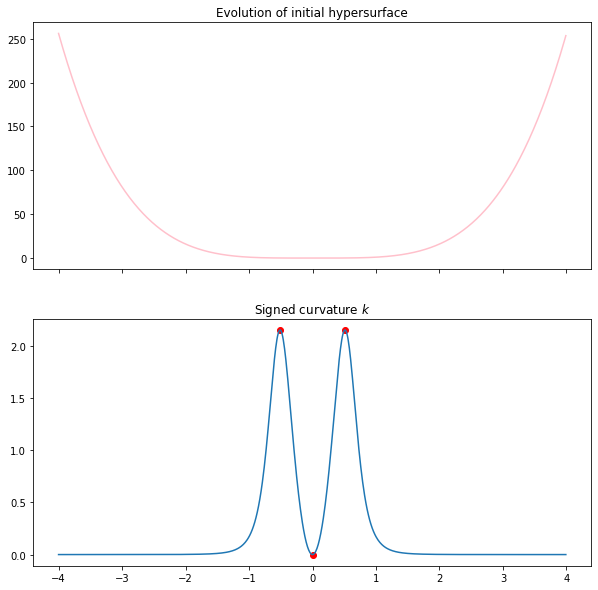

In [12]:
main()